In [2]:
import os
import mat73
import matplotlib.pyplot as plt
import numpy as np
path = '../datasets/dataset2_grasping-task/'
fname = os.path.join(path, 'Dataset2.mat')

from scipy.io import loadmat
DATA = mat73.loadmat(fname)

In [3]:
DATA.keys()

dict_keys(['monkeyL', 'monkeyN'])

In [4]:
%whos

Variable   Type        Data/Info
--------------------------------
DATA       dict        n=2
fname      str         ../datasets/dataset2_grasping-task/Dataset2.mat
loadmat    function    <function loadmat at 0x121c79c20>
mat73      module      <module 'mat73' from '/Us<...>kages/mat73/__init__.py'>
np         module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
os         module      <module 'os' from '/Users<...>da3/lib/python3.7/os.py'>
path       str         ../datasets/dataset2_grasping-task/
plt        module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>


In [5]:
DATA['monkeyL'].keys()

dict_keys(['MT', 'PT', 'RT', 'force', 'grip', 'neuron', 'spikes'])

In [6]:
nTime, nNeuron, nTrial = DATA['monkeyL']['spikes'].shape
spikes = DATA['monkeyL']['spikes']
neurons = DATA['monkeyL']['neuron']
grips = DATA['monkeyL']['grip']
forces = DATA['monkeyL']['force']

# without smoothing

In [ ]:
for j in range(134):
    s = 0
    for i in range(20):
        s = s + spikes[i][0][j]
    print(s)

In [7]:
# Use 20-ms non-overlapping windows to bin the spikes.
bin_spikes = spikes.reshape(int(5500/20), 20, 93, 134)
bin_spikes = bin_spikes.sum(axis = 1)

In [8]:
fr = bin_spikes/20*1000

In [9]:
fr_avg = np.mean(bin_spikes, axis = 2)/20*1000


In [12]:
SG_fr = fr[:,:,:70]
PG_fr = fr[:,:,70:]

In [14]:
trail_averaged_fr_SG = np.mean(SG_fr, axis = 2)
trail_averaged_fr_PG = np.mean(PG_fr, axis = 2)

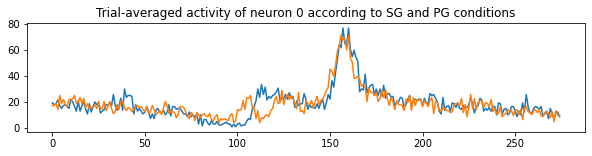

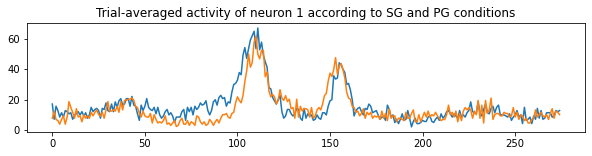

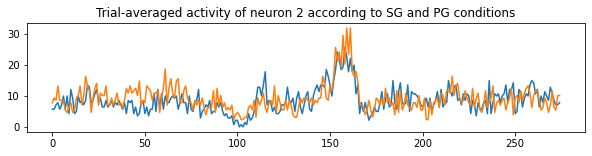

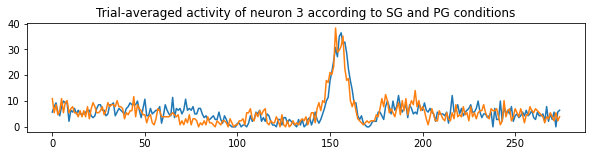

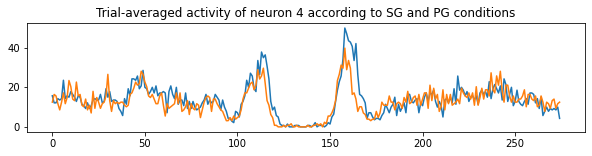

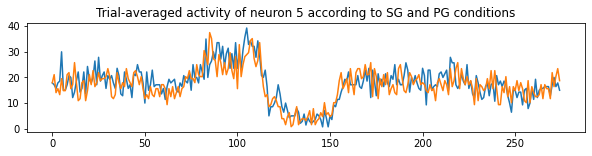

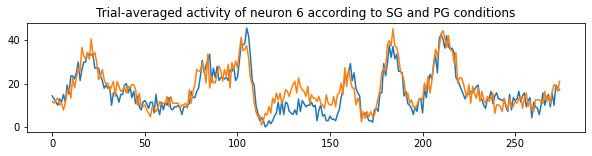

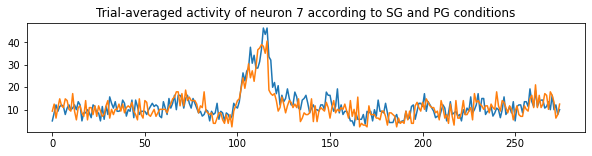

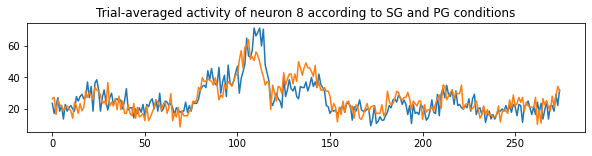

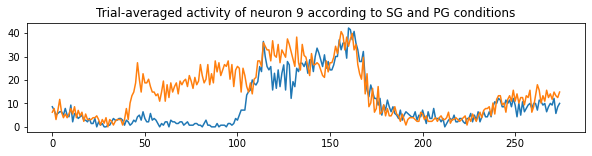

In [15]:
for i in range(10):
    plt.figure(figsize=(10,2))
    plt.plot(trail_averaged_fr_SG[:,i])
    plt.plot(trail_averaged_fr_PG[:,i])
    plt.title(f'Trial-averaged activity of neuron {i} according to SG and PG conditions')

# Smoothing

In [33]:
from scipy.ndimage import convolve1d
def gaussian_filter1d(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

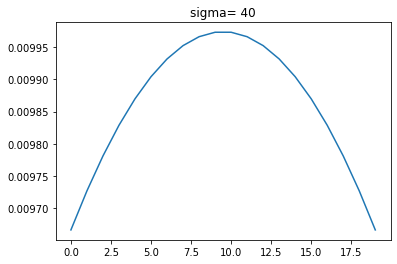

In [21]:
fig,ax = plt.subplots()
ax.plot(gaussian_filter1d(size=20,sigma=40))
ax.set_title(f'sigma= 40')
plt.show()

In [24]:
# smoothed_bin_spikes = convolve1d(bin_spikes, gaussian_filter1d(size=20,sigma=40), axis=0)
smoothed_fr = convolve1d(fr, gaussian_filter1d(size=20,sigma=40), axis=0)
smoothed_fr_avg = convolve1d(fr_avg, gaussian_filter1d(size=20,sigma=40), axis=0)

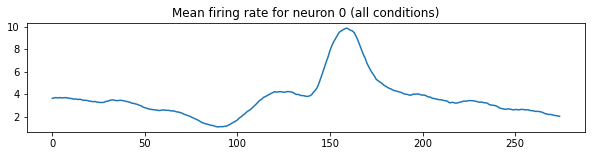

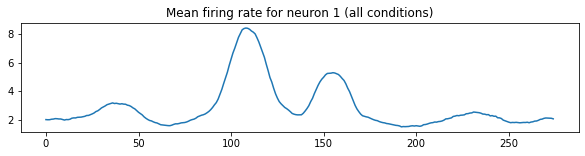

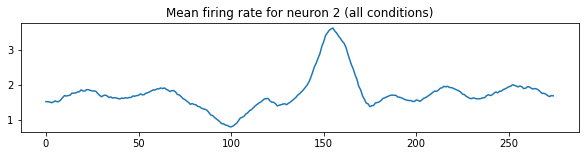

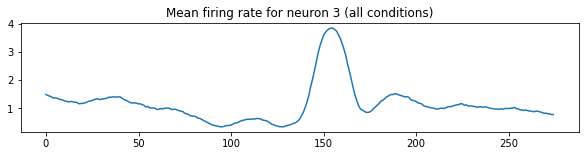

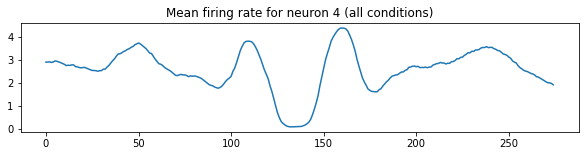

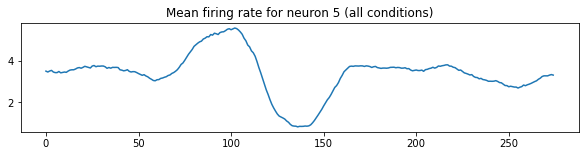

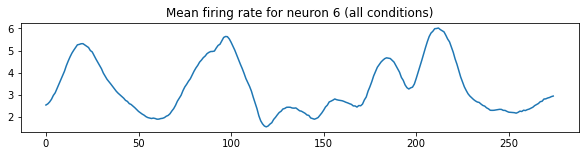

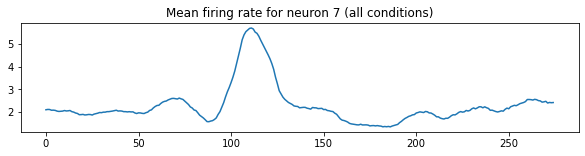

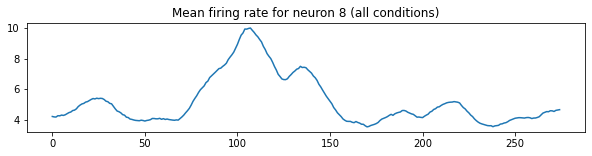

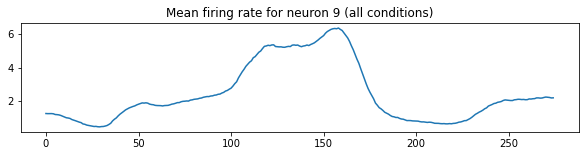

In [25]:
for i in range(10):
    plt.figure(figsize=(10,2))
    plt.plot(smoothed_fr_avg[:,i])
    plt.title(f'Mean firing rate for neuron {i} (all conditions)')

In [27]:
fs = 50
t_stamps = np.arange(0,fr.shape[0]/fs, 1/fs)

In [29]:
states = ['CUE_ON', 'CUE_OFF', 'GO'] # cues
states_ind = [0.7,1,2] # time at which transition occurs (in seconds)

all_cond = ['PG/HF', 'PG/LF', 'SG/HF', 'SG/LF']
all_cond_ind = [(2,1), (2,2), (1,1), (1,2)]

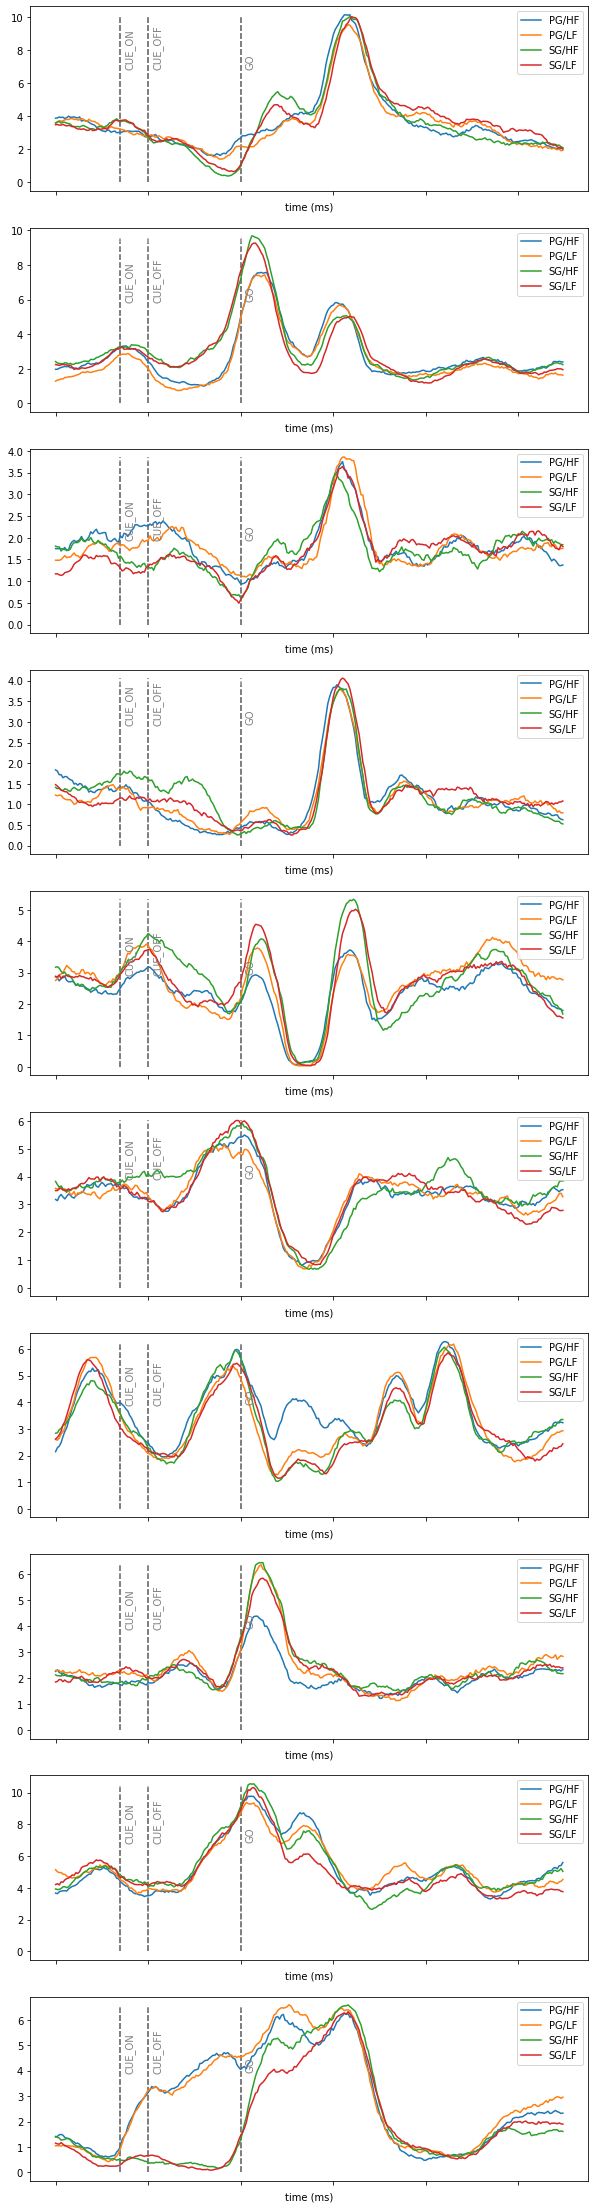

In [34]:
n_plot = 10
fig, axes = plt.subplots(n_plot, 1, figsize=(10,4*n_plot))
for i in range(n_plot):   
    for (j, cond) in enumerate(all_cond):    
        grip_mask = all_cond_ind[j][0] 
        force_mask = all_cond_ind[j][1] 
        cond_trials_mask = (grips == grip_mask) & (forces == force_mask)
        trail_avg_smoothed_fr  = np.mean(smoothed_fr[:,i,cond_trials_mask], 1) 
        
        axes[i].plot(t_stamps, trail_avg_smoothed_fr, label=cond)
        axes[i].vlines(states_ind, ymin=0, ymax=np.max(trail_avg_smoothed_fr), linestyles='dashed', color='grey')
        axes[i].legend(loc='upper right')
        axes[i].set_xticklabels([])
        axes[i].set_xlabel('time (ms)')
    for k in range(3):
            axes[i].text(states_ind[k]+0.05, round(np.max(trail_avg_smoothed_fr)/1.5), states[k], rotation=90, color='grey')
        

# Bootstrap to test variance on conditions

In [41]:
PG_HF = smoothed_fr[:,:,(grips == 2) & (forces == 1)]
PG_LF = smoothed_fr[:,:,(grips == 2) & (forces == 2)]
SG_HF = smoothed_fr[:,:,(grips == 1) & (forces == 1)]
SG_LF = smoothed_fr[:,:,(grips == 1) & (forces == 2)]

In [42]:
print(PG_HF.shape, PG_LF.shape, SG_HF.shape, SG_LF.shape)

(275, 93, 33) (275, 93, 31) (275, 93, 30) (275, 93, 40)


In [44]:
from sklearn.utils import resample

In [69]:
# cond_trials_mask = (grips == 2) & (forces == 1)
# trail_avg_smoothed_fr  = PG_HF[:,0,:]
# boot = resample(trail_avg_smoothed_fr.T, replace=True, n_samples=5, random_state=1)
# plt.plot(np.min(boot.T, axis=1))   
# plt.plot(np.max(boot.T, axis=1))
# plt.fill_between(range(len(t_stamps)), np.min(boot.T, axis=1), np.max(boot.T, axis=1), alpha=0.3)     

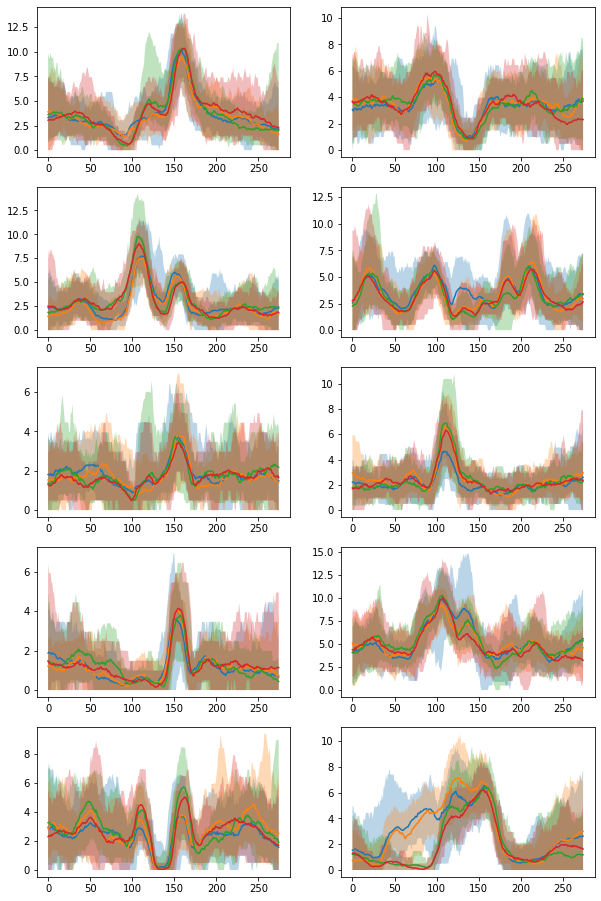

In [66]:
fig, axes = plt.subplots(5, 2, figsize=(10,4*4))
for i in range(10):    
    boot = resample(PG_HF[:,i,:].T, replace=True, n_samples=PG_HF.shape[2], random_state=1)
#     axes[i%5,i//5].fill_between(range(len(t_stamps)), np.min(boot.T, axis=1), np.max(boot.T, axis=1), alpha=0.3)
    lower = np.percentile(boot, [2.5, 97.5], axis=0)[0]
    upper = np.percentile(boot, [2.5, 97.5], axis=0)[1]
    axes[i%5,i//5].plot(range(len(t_stamps)), np.mean(boot.T, axis=1))
    axes[i%5,i//5].fill_between(range(len(t_stamps)), lower, upper, alpha=0.3)
    
    boot = resample(PG_LF[:,i,:].T, replace=True, n_samples=PG_LF.shape[2], random_state=1)
#     axes[i%5,i//5].fill_between(range(len(t_stamps)), np.min(boot.T, axis=1), np.max(boot.T, axis=1), alpha=0.3)
    lower = np.percentile(boot, [2.5, 97.5], axis=0)[0]
    upper = np.percentile(boot, [2.5, 97.5], axis=0)[1]
    axes[i%5,i//5].plot(range(len(t_stamps)), np.mean(boot.T, axis=1))
    axes[i%5,i//5].fill_between(range(len(t_stamps)), lower, upper, alpha=0.3)
    
    boot = resample(SG_HF[:,i,:].T, replace=True, n_samples=SG_HF.shape[2], random_state=1)
    lower = np.percentile(boot, [2.5, 97.5], axis=0)[0]
    upper = np.percentile(boot, [2.5, 97.5], axis=0)[1]
    axes[i%5,i//5].plot(range(len(t_stamps)), np.mean(boot.T, axis=1))
    axes[i%5,i//5].fill_between(range(len(t_stamps)), lower, upper, alpha=0.3)
    
    boot = resample(SG_LF[:,i,:].T, replace=True, n_samples=SG_LF.shape[2], random_state=1)
    lower = np.percentile(boot, [2.5, 97.5], axis=0)[0]
    upper = np.percentile(boot, [2.5, 97.5], axis=0)[1]
    axes[i%5,i//5].plot(range(len(t_stamps)), np.mean(boot.T, axis=1))
    axes[i%5,i//5].fill_between(range(len(t_stamps)), lower, upper, alpha=0.3)


# PCA



In [67]:
from sklearn.decomposition import PCA

In [133]:
time_scale = 100
PGHF_avg = np.mean(PG_HF, axis=2)[:time_scale]
PGLF_avg = np.mean(PG_LF, axis=2)[:time_scale]
SGHF_avg = np.mean(SG_HF, axis=2)[:time_scale]
SGLF_avg = np.mean(SG_LF, axis=2)[:time_scale]

In [134]:
PSTH_concat = np.concatenate((PGHF_avg, PGLF_avg, SGHF_avg, SGLF_avg), axis = 0)

In [135]:
data_mean = np.mean(PSTH_concat, axis=0)

In [136]:
pca = PCA(n_components=10)
pca.fit((PSTH_concat - data_mean))

PCA(n_components=10)

In [137]:
pca.explained_variance_

array([37.2562937 , 18.09308618,  9.15774851,  5.30874503,  2.27567392,
        1.71803273,  1.18024284,  0.76058579,  0.60025383,  0.46331812])

In [138]:
mat_coeff = pca.components_.T[:,:3]

In [139]:
score_cond1 =  (PGHF_avg - data_mean) @ mat_coeff
score_cond2 =  (PGLF_avg - data_mean) @ mat_coeff 
score_cond3 =  (SGHF_avg - data_mean) @ mat_coeff 
score_cond4 =  (SGLF_avg - data_mean) @ mat_coeff 

In [142]:
ax.legend?

Signature: ax.legend(*args, **kwargs)
Docstring:
Place a legend on the axes.

Call signatures::

    legend()
    legend(labels)
    legend(handles, labels)

The call signatures correspond to three different ways how to use
this method.

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    line, = ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

Specific lines can be excluded from the automatic legend element
selection by defining a label starting with an underscore.
This is default for all artists, so calling `.Axes.legend` without
any arguments and without setting the labels manually will 

In [143]:
all_cond

['PG/HF', 'PG/LF', 'SG/HF', 'SG/LF']

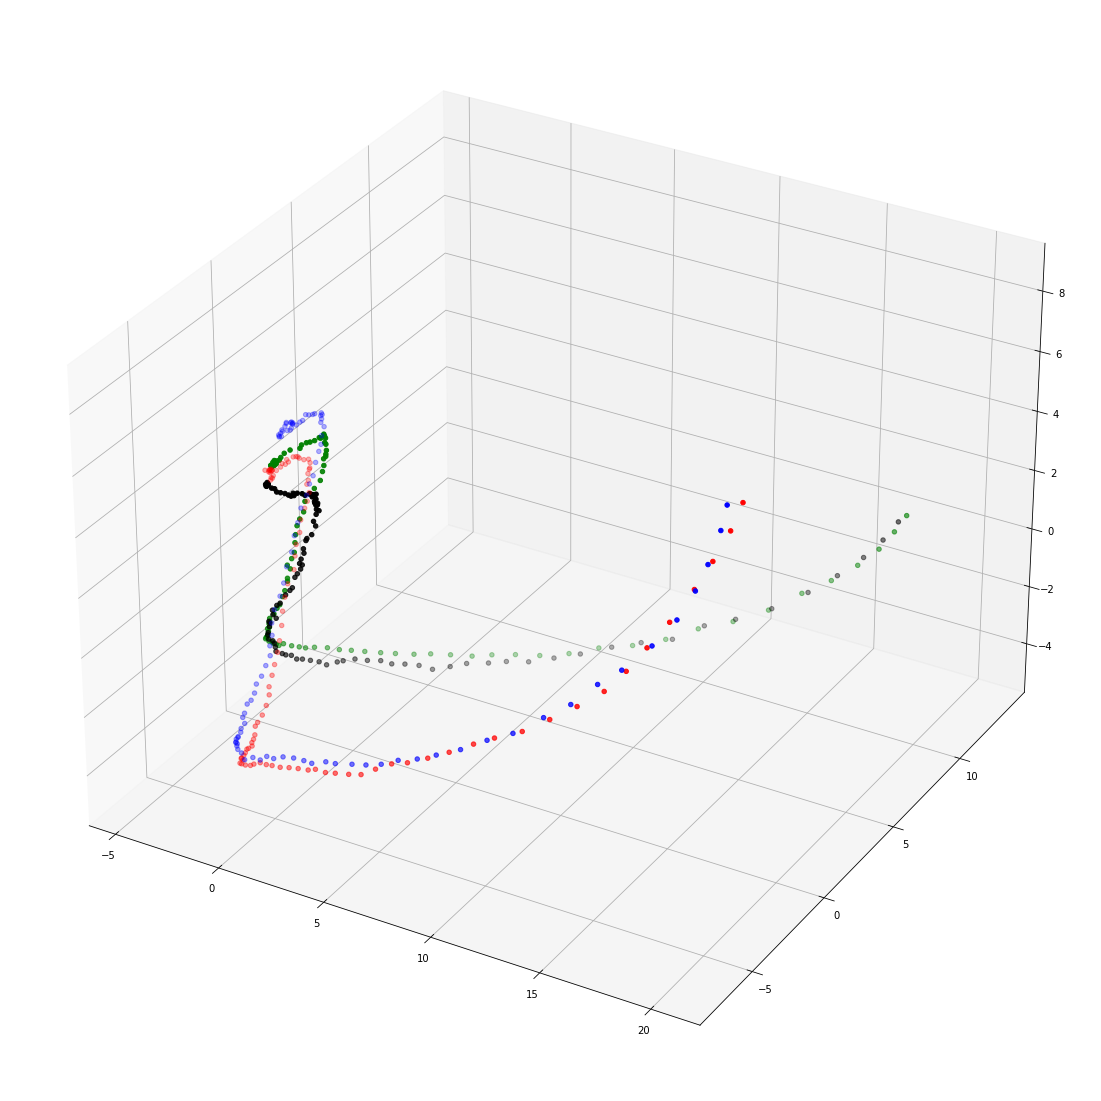

In [146]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection="3d")

ax.scatter3D(score_cond1[:,0], score_cond1[:,1], score_cond1[:,2], c='r');
ax.scatter3D(score_cond2[:,0], score_cond2[:,1], score_cond2[:,2], c='b');
ax.scatter3D(score_cond3[:,0], score_cond3[:,1], score_cond3[:,2], c='k');
ax.scatter3D(score_cond4[:,0], score_cond4[:,1], score_cond4[:,2], c='g');

